<a href="https://colab.research.google.com/github/awoland/face_segmentation/blob/master/face_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключаем Google диск

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Установка зависимостей

In [ ]:
!pip3 uninstall keras-nightly
!pip3 uninstall -y tensorflow
!pip3 install tensorflow==1.15.0
!pip3 install tensorflow-gpu==1.15.0
!pip install keras==2.3.0
!pip install 'h5py==2.10.0' --force-reinstall
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user

После установки зависимостей неоходимо перезапустить среду выполнения с помощью главного меню

# Тренировка Модели

Наши данные на Google диске, извлекаем их в папку `'/content/data/'`

In [ ]:
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/face_segmentation_data.zip', 'r') as zipObj:
   zipObj.extractall('/content/data/') 

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import numpy as np 
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
import albumentations as A
import segmentation_models as sm

image_size = 512
DATA_DIR = "/content/data/"

x_train_dir = os.path.join(DATA_DIR, 'image')
y_train_dir = os.path.join(DATA_DIR, 'mask')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valmask')

In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(36, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)        
    plt.show()
    
def denormalize(x):
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

class Dataset:
    CLASSES = ['none', 'lip_up', 'lip_down', 'brow_l', 'brow_r', 'eye_l', 'eye_r']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_ids = os.listdir(images_dir)
        self.masks_ids = os.listdir(masks_dir)

        self.images_ids.sort()
        self.masks_ids.sort()

        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.images_ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.masks_ids]
        
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):      
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']    
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_ids)
        
class Dataloder(keras.utils.Sequence):
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [
        A.ShiftScaleRotate(p=0.25, border_mode=0),
        A.IAAPerspective(p=0.25),  
        A.Rotate(p=0.25, limit=(90, 90), interpolation=2),  
        A.Rotate(p=0.25, limit=(-90, -90), interpolation=2),                                
        A.Resize(image_size, image_size, interpolation=2, always_apply=True),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        A.Resize(image_size, image_size, interpolation=2, always_apply=True),
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['none', 'lip_up', 'lip_down', 'brow_l', 'brow_r', 'eye_l', 'eye_r'], augmentation=get_training_augmentation())

image, mask = dataset[345] 
visualize(
    image=image,
    none=mask[..., 0].squeeze(),
    lip_up=mask[..., 1].squeeze(),
    lip_down=mask[..., 2].squeeze(),
    brow_l=mask[..., 3].squeeze(),
    brow_r=mask[..., 4].squeeze(),
    eye_l=mask[..., 5].squeeze(),
    eye_r=mask[..., 6].squeeze(),
)

In [ ]:
dataset = Dataset(x_valid_dir, y_valid_dir, classes=['none', 'lip_up', 'lip_down', 'brow_l', 'brow_r', 'eye_l', 'eye_r'], augmentation=get_validation_augmentation())

image, mask = dataset[345] 
visualize(
    image=image,
    none=mask[..., 0].squeeze(),
    lip_up=mask[..., 1].squeeze(),
    lip_down=mask[..., 2].squeeze(),
    brow_l=mask[..., 3].squeeze(),
    brow_r=mask[..., 4].squeeze(),
    eye_l=mask[..., 5].squeeze(),
    eye_r=mask[..., 6].squeeze(),
)

In [ ]:
"""
DenseNet	'densenet121' 'densenet169' 'densenet201'
Inception	'inceptionv3' 'inceptionresnetv2'
MobileNet	'mobilenet' 'mobilenetv2'
EfficientNet	'efficientnetb0' 'efficientnetb1' 'efficientnetb2' 'efficientnetb3' 'efficientnetb4' 'efficientnetb5' efficientnetb6' efficientnetb7'
"""

In [ ]:
BACKBONE = 'efficientnetb0'
BATCH_SIZE = 8
CLASSES = ['none', 'lip_up', 'lip_down', 'brow_l', 'brow_r', 'eye_l', 'eye_r']
LR = 0.0001
EPOCHS = 100

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1) 
activation = 'sigmoid' if n_classes == 1 else 'softmax'

model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(image_size, image_size, 3), decoder_filters=(512, 256, 128, 64, 32), activation=activation)

При необходимости загрузите ранее натренированную модель и продолжите тренировку

In [ ]:
#model.load_weights("/content/drive/MyDrive/segmentation_unet_b0_512.h5");

In [ ]:
optim = keras.optimizers.Adam(LR)
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

assert train_dataloader[0][0].shape == (BATCH_SIZE, image_size, image_size, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, image_size, image_size, n_classes)
   
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/My Drive/segmentation_unet_b0_512.h5', save_weights_only=False, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),         
]

In [ ]:
model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

# Тестирование Модели

In [ ]:
test_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model.load_weights('/content/drive/My Drive/segmentation_unet_b0_512.h5')

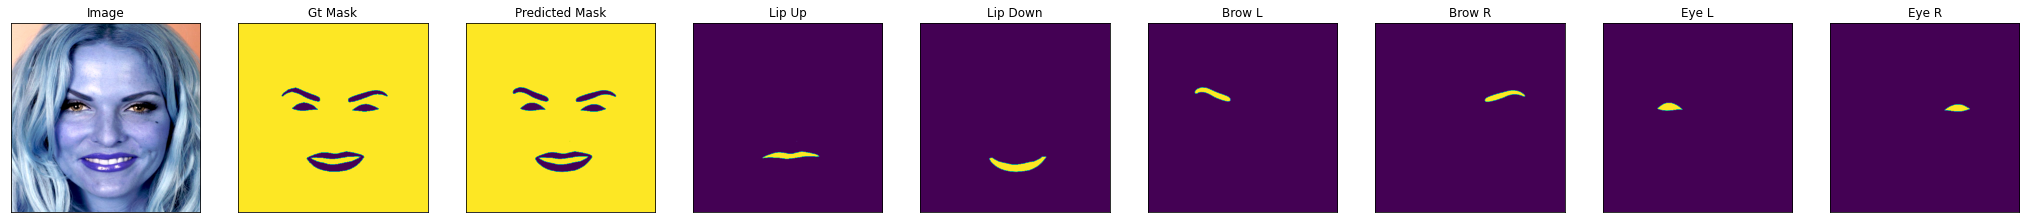

In [ ]:
n = 1
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:    
    image, gt_mask = test_dataset[i]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, axis=0)
    
    predicted = model.predict(image)

    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        #
        predicted_mask=predicted[..., 0].squeeze(),
        lip_up=predicted[..., 1].squeeze(),
        lip_down=predicted[..., 2].squeeze(),
        brow_l=predicted[..., 3].squeeze(),
        brow_r=predicted[..., 4].squeeze(),
        eye_l=predicted[..., 5].squeeze(),
        eye_r=predicted[..., 6].squeeze(),
    )